# Set Parameter
- Attention = [None, Luong]
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = 50
- Epochs = 100
- N = 100
- Data Length = 100K
- Single
- Cype = 2
- Deduplication

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentance_accuracy = []

In [4]:
train_path = "data/palindrome_dedup/K100_single_Ctype2/data_train.txt"
dev_path = "data/palindrome_dedup/K100_single_Ctype2/data_test.txt"

src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()
    
optimizer = "Adam"
hidden_size = 50
bidirectional = True

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Prepare dataset

In [ ]:
print("None Att")

seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="palindrome_dedup_K100_single_Ctype2_parameter/None_att")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

character_accuracy.append(character_accuracy_list)
sentance_accuracy.append(sentance_accuracy_list)

torch.save(seq2seq.state_dict(), 'log/pth/palindrome_dedup_K100_single_Ctype2_parameter_no_att_model_save.pth')

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-03-25 01:08:46,450 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


None Att


2019-03-25 01:11:46,173 INFO   Finished epoch 1: Train loss: 16.6451, Dev loss: 19.0894, Accuracy(Character): 0.4423, Accuracy(Word): 0.0000
2019-03-25 01:14:46,362 INFO   Finished epoch 2: Train loss: 7.4618, Dev loss: 12.3162, Accuracy(Character): 0.4932, Accuracy(Word): 0.0005
2019-03-25 01:17:46,207 INFO   Finished epoch 3: Train loss: 6.3872, Dev loss: 17.8174, Accuracy(Character): 0.4848, Accuracy(Word): 0.0004
2019-03-25 01:20:46,300 INFO   Finished epoch 4: Train loss: 6.3490, Dev loss: 10.5163, Accuracy(Character): 0.4949, Accuracy(Word): 0.0000
2019-03-25 01:23:46,944 INFO   Finished epoch 5: Train loss: 6.6593, Dev loss: 11.4689, Accuracy(Character): 0.4875, Accuracy(Word): 0.0000
2019-03-25 01:26:48,399 INFO   Finished epoch 6: Train loss: 6.3352, Dev loss: 16.4792, Accuracy(Character): 0.4892, Accuracy(Word): 0.0000
2019-03-25 01:29:48,960 INFO   Finished epoch 7: Train loss: 6.0110, Dev loss: 25.6438, Accuracy(Character): 0.4870, Accuracy(Word): 0.0000
2019-03-25 01:32:50

In [ ]:
print("Luong Att")

seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="palindrome_dedup_K100_single_Ctype2_parameter/Luong_att")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

character_accuracy.append(character_accuracy_list)
sentance_accuracy.append(sentance_accuracy_list)

torch.save(seq2seq.state_dict(), 'log/pth/palindrome_dedup_K100_single_Ctype2_parameter_Luong_att_model_save.pth')

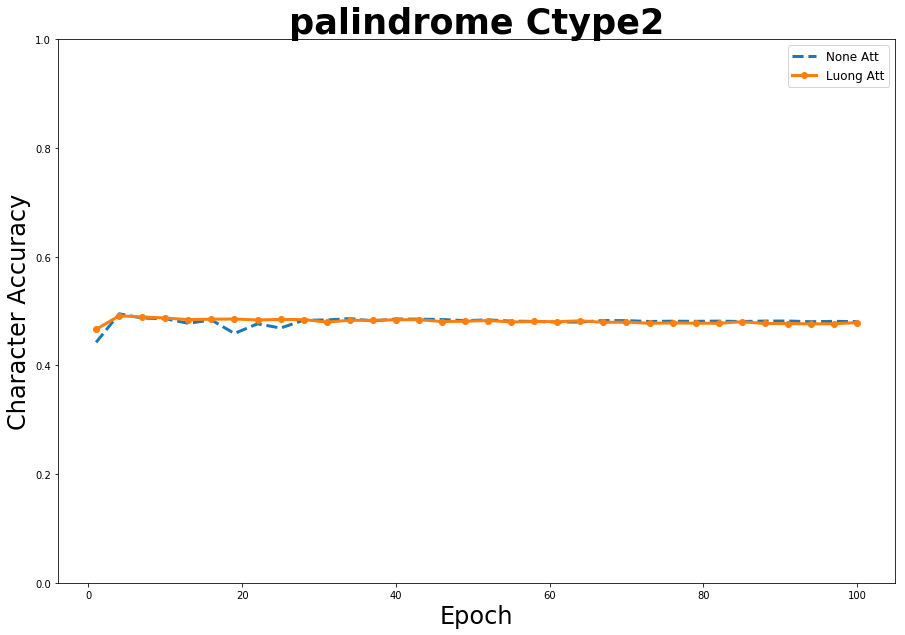

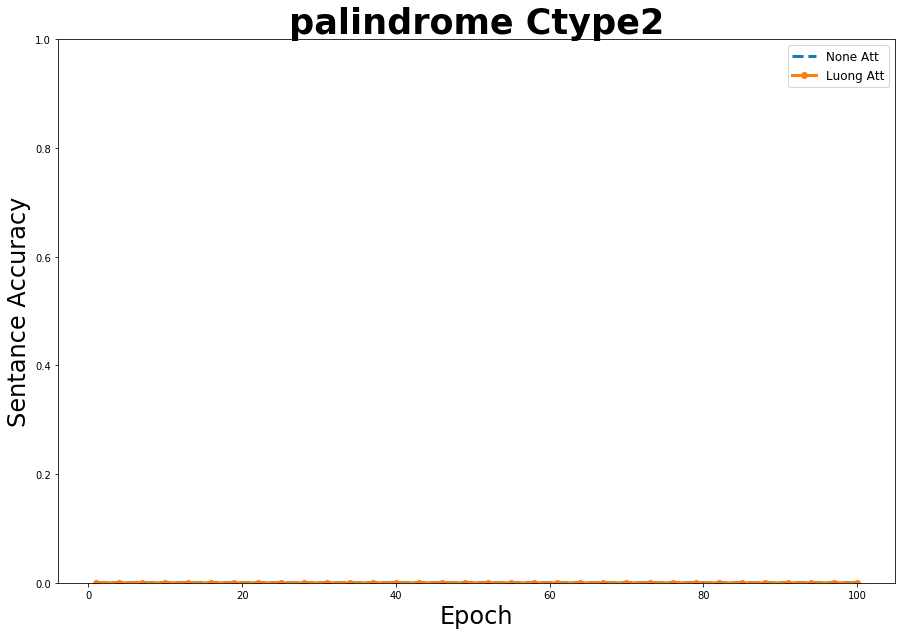

In [10]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,10))
plt.plot(epochs[::3], character_accuracy[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], character_accuracy[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('palindrome Ctype2', fontsize=35, fontweight=560)
plt.savefig('log/plot/palindrome_dedup_K100_single_Ctype2_parameter/epoch_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], sentance_accuracy[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], sentance_accuracy[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentance Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('palindrome Ctype2', fontsize=35, fontweight=560)
plt.savefig('log/plot/palindrome_dedup_K100_single_Ctype2_parameter/epoch_to_sentance_accuracy.png')

In [11]:
print(character_accuracy[0])
print(character_accuracy[1])

[0.4422865575245322, 0.49316148692512535, 0.48483511191578627, 0.49486206646931735, 0.4875239863783308, 0.48918508057913385, 0.48701377380395217, 0.48568869213316473, 0.48674318306837505, 0.48578701838042737, 0.47977711684990576, 0.47618588615756124, 0.4774056735793115, 0.4807011513074488, 0.4830710461332042, 0.48345622178685116, 0.48419444286374036, 0.48380152498589946, 0.4586617488058587, 0.4790106366547088, 0.483840236106869, 0.4764421537783796, 0.48557333299267547, 0.48530622625798564, 0.4686345077900324, 0.4850364097448279, 0.4855888174410633, 0.4830710461332042, 0.48465742787053606, 0.48354370892024234, 0.48347402890249713, 0.48371055385162104, 0.485078217755475, 0.4860305113313258, 0.4848517576978032, 0.4854932009722685, 0.48189500227814946, 0.48324331062151865, 0.4837299094121058, 0.48524351424201495, 0.4857924379373631, 0.4835789360403246, 0.48504299063539275, 0.48375429741831666, 0.4833404755351522, 0.4843229637853592, 0.4800109320205618, 0.483265763071681, 0.4823386317244604

In [12]:
print(sentance_accuracy[0])
print(sentance_accuracy[1])

[2.0876390889543015e-05, 0.0004592805995699463, 0.0003757750360117743, 2.0876390889543015e-05, 2.0876390889543015e-05, 0.0, 0.0, 0.0, 0.0, 4.175278177908603e-05, 0.0, 2.0876390889543015e-05, 2.0876390889543015e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0876390889543015e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.00014613473622680112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0